# Graph-UNets

Hereafter is a modification of the implementation of the paper. Only the encoder is considered here, we can think of it as a graph CNN. We did a version using GeneralConv with attention.

## Imports

In [1]:
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from tqdm import tqdm
from torch import nn
from torch_geometric.nn import GCNConv,TopKPooling,global_mean_pool, GraphConv, GeneralConv
from torch_geometric import seed_everything
from torch_geometric.utils.convert import to_scipy_sparse_matrix
from torch_geometric.utils.sparse import dense_to_sparse,to_torch_coo_tensor
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

## Dataset

For our experiment we picked the PROTEINS dataset, which is one of those selected in the Graph-UNets paper.  
The dataset was divided as such:
- 81% for the training set
- 9% for the validation set
- 10 % for the test set

In [2]:
seed_everything(77) #Seed for all random actions, this library is a proxy for other libraries, e.g. pytorch
path=""
dataset = TUDataset(path, name='PROTEINS').shuffle() #Here we shuffle the dataset to break any potential order correlation

print("Dataset is undirected? ", dataset[0].is_undirected()) #This is a vital information!
print ("Len of dataset: ", len(dataset))
train_set = dataset[:int(0.9*len(dataset))]
train_dataset = train_set[:int(0.9*len(train_set))]
val_dataset = train_set[int(0.9*len(train_set)):]
test_dataset = dataset[int(0.9*len(dataset)):]
print("Len of train dataset: ", len(train_dataset))
print("Len of validation dataset: ",len(val_dataset))
print("Len of test dataset: ",len(test_dataset))

batch_size=128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Dataset is undirected?  True
Len of dataset:  1113
Len of train dataset:  900
Len of validation dataset:  101
Len of test dataset:  112


## Graph Pooling

![title](graphpool.png)

In [11]:
class gPool(nn.Module):
    """
    Our implementation of the pooling methodology described in the paper, above you can see the pseudocode
    """
    def __init__(self,in_dim,ratio):
        super().__init__()
        self.in_dim=in_dim
        self.ratio=ratio
        self.p=nn.Linear(in_dim,1)
        self.sigmoid=nn.Sigmoid()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def forward(self,xl,edge_index,batch):
        
        #y is described as a learnable projection, hence we estimated a linear layer to be a suitable choice
        
        y=self.p(xl) #/torch.norm(self.p(xl)) #DO WE HAVE TO INSERT THE NORM?
        
        k=int(self.ratio*len(y))#Number of selected nodes, the k in TopkPooling
        
        topks, idx =torch.topk(y,k,dim=0) #The k elements with top scores, and their corresponding idx
        
        y_hat=self.sigmoid(topks)
        xl_hat=xl[idx,:].squeeze() #Feature matrix of topk nodes
        xl1=xl_hat * y_hat  #Gate operation
        
        al = torch.as_tensor(to_scipy_sparse_matrix(edge_index,num_nodes=len(y)).todense(), device = self.device)
        al1 = torch.index_select(torch.as_tensor(al),0,idx.squeeze()) #no direct indexing because of ram overloading
        al1=torch.index_select(al1,1,idx.squeeze())
        sparsel1=dense_to_sparse(al1)
        edge_index_pooled=torch.sparse_coo_tensor(sparsel1[0],sparsel1[1]).coalesce().indices() #Our model elaborates coo tensors
        
        batch = batch[idx.squeeze()]
        
        return xl1, edge_index_pooled, idx.squeeze(), batch

In [4]:
"""
Simple example to prove that dim=0 in the norm is not equal for all inputs, depends on the dimension
p=nn.Linear(4,1)
xl=torch.ones((6,4))
y=p(xl)/torch.norm(p(xl))
xl2=torch.ones((2,4))
print(torch.norm(p(xl),dim=0))
print(torch.norm(p(xl2),dim=0))
"""

'\nSimple example to prove that dim=0 in the norm is not equal for all inputs, depends on the dimension\np=nn.Linear(4,1)\nxl=torch.ones((6,4))\ny=p(xl)/torch.norm(p(xl))\nxl2=torch.ones((2,4))\nprint(torch.norm(p(xl),dim=0))\nprint(torch.norm(p(xl2),dim=0))\n'

## Graph Unpooling

In [12]:
class gUnpool(nn.Module):
    """
    Our implementation of the unpooling methodology described in the paper
    """
    def __init__(self,in_dim,out_dim):
        super().__init__()
        self.in_dim=in_dim
        self.out_dim=out_dim
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def forward(self,xl,idx,up_shape):
        up_nodes,C = up_shape #We extract the number of nodes and features the graph has to return to
        xl1=torch.zeros((up_nodes,xl.shape[1]), device = self.device)
        xl1[idx]=xl #We fetch the current feature matrix and sorround it of zeros to have the desired shape
        return xl1
        

## U-Net

The U-Net as described in the paper, below is the graphical representation in the paper, however the number of up and down blocks is inferior with respect to the paper description, which is four upblocks and four downblocks as presented in the code below.

![title](unet_structure.png)

In [13]:
class UNet(nn.Module):
    def __init__(self, improved = False, dropout = 0.3 ):
        super().__init__()
        self.in_conv = GeneralConv(dataset.num_features, 16, directed_msg = False,attention= True, attention_type= 'dot_product')
        #heads = 4, 
        #attention= False
        #l2_normalize= False
        
        self.GC1 =GeneralConv(16, 32, directed_msg = False, attention= True, attention_type= 'dot_product')
        self.GC2 =GeneralConv(32, 64,  directed_msg = False, attention= True, attention_type= 'dot_product')
        self.GC3 =GeneralConv(64, 128,  directed_msg = False, attention= True, attention_type= 'dot_product')
        self.GC4 =GeneralConv(128, 256,  directed_msg = False, attention= True, attention_type= 'dot_product')
        self.act=nn.LeakyReLU()
        
        self.gPool1 = gPool(16, 0.9)
        self.gPool2 = gPool(32, 0.7)
        self.gPool3 = gPool(64, 0.6)
        self.gPool4 = gPool(128, 0.5)
        
        self.out_conv = GeneralConv(256, dataset.num_features, directed_msg = False, attention= True, attention_type= 'dot_product')
        
        self.linear = nn.Linear(dataset.num_features, 1)
        
    
    def forward(self,x,edge_index,batch, batch_size):
        x1 = self.in_conv(x, edge_index)
        x1 = self.act(x1)
        
        # Encoder
        
        #Pool1
        x2, edge_index2, idx2, batch = self.gPool1(x1,edge_index, batch)
        x2 = self.act(x2)
        
        x3 = self.GC1(x2, edge_index2)
        x3 = self.act(x3)
        
        #Pool2
        x4,  edge_index4, idx4, batch = self.gPool2(x3,edge_index2, batch)
        x4 = self.act(x4)
        
        x5 = self.GC2(x4, edge_index4)
        x5 = self.act(x5)
        
        #Pool3
        x6,  edge_index6, idx6, batch = self.gPool3(x5,edge_index4, batch)
        x6 = self.act(x6)
        
        x7 = self.GC3(x6, edge_index6)
        x7 = self.act(x7)
        
        #Pool4
        x8,  edge_index8, idx8, batch = self.gPool4(x7,edge_index6, batch)
        x8 = self.act(x8)
        
        x9 = self.GC4(x8, edge_index8)
        x9 = self.act(x9)
        
        x18 = self.out_conv(x9, edge_index8)
        x18 = self.act(x18)
        
        #Readout
        x19 = global_mean_pool(x18, batch, batch_size) #readout layer commonly adoperated - reference: https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing#scrollTo=CN3sRVuaQ88l
        x19 = self.act(x19)
        
        #Linear
        x19=self.linear(x19)
        
        return x19

## Parameters customization

In [14]:
seed_everything(77)
lrate =0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=UNet().to(device) #Customize the model by changing these parameters

optimizer = torch.optim.Adam(model.parameters(), lr=lrate) #Adam because it is adaptive
criterion=nn.BCEWithLogitsLoss()
sigmoid=nn.Sigmoid()
epochs=200

## Training

Here we start the training of the model, we perform one epoch on the training set and one on the validation set.

In [15]:
seed_everything(77)
train_losses=[]
val_losses=[]
train_accuracies=[]
val_accuracies=[]
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_acc=0.0
    for i, data in enumerate(tqdm(train_loader)):
        data = data.to(device) #E.g. DataBatch(edge_index=[2, 19062], x=[5024, 3], y=[128], batch=[5024], ptr=[129])
        optimizer.zero_grad()
        pred = model(data.x, data.edge_index, data.batch, data.y.shape[0])
        loss = criterion(pred.squeeze(), data.y.type(torch.float))
        loss.backward()
        probs=sigmoid(pred.squeeze())
        acc=accuracy_score(data.y.cpu(),torch.round(probs).detach().cpu())
        train_acc+=acc
        train_loss += loss.item()
        optimizer.step()
        
    epoch_train_loss=train_loss/len(train_loader) #We compute the average train loss for each epoch
    train_losses.append(epoch_train_loss)
    epoch_train_accuracy=train_acc/len(train_loader) #We compute the average train accuracy for each epoch
    train_accuracies.append(epoch_train_accuracy)
    print(f"Training loss epoch {epoch}: ", epoch_train_loss)
    print(f"Training accuracy epoch {epoch}: ", epoch_train_accuracy)
    
    model.eval()
    val_loss = 0.0
    val_acc=0.0
    for i, data in enumerate(tqdm(val_loader)):
        data = data.to(device)
        pred = model(data.x, data.edge_index, data.batch, data.y.shape[0])
        loss = criterion(pred.squeeze(), data.y.type(torch.float))
        probs=sigmoid(pred.squeeze())
        acc=accuracy_score(data.y.cpu(),torch.round(probs).detach().cpu())
        val_acc+=acc
        val_loss += loss.item()
    
    epoch_val_loss=val_loss/len(val_loader) #We compute the average train loss for each epoch
    val_losses.append(epoch_val_loss)
    epoch_val_accuracy=val_acc/len(val_loader) #We compute the average train accuracy for each epoch
    val_accuracies.append(epoch_val_accuracy)
    print(f"Validation loss epoch {epoch}: ", epoch_val_loss)
    print(f"Validation accuracy epoch {epoch}: ", epoch_val_accuracy)
print('Finished Training')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.94it/s]


Training loss epoch 0:  0.7508604377508163
Training accuracy epoch 0:  0.408203125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


Validation loss epoch 0:  0.746738851070404
Validation accuracy epoch 0:  0.4158415841584158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.64it/s]


Training loss epoch 1:  0.7372998669743538
Training accuracy epoch 1:  0.4384765625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.61it/s]


Validation loss epoch 1:  0.7453551292419434
Validation accuracy epoch 1:  0.4158415841584158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.07it/s]


Training loss epoch 2:  0.7595332488417625
Training accuracy epoch 2:  0.3779296875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.99it/s]


Validation loss epoch 2:  0.7440955638885498
Validation accuracy epoch 2:  0.4158415841584158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.53it/s]


Training loss epoch 3:  0.769391655921936
Training accuracy epoch 3:  0.34765625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


Validation loss epoch 3:  0.742713451385498
Validation accuracy epoch 3:  0.4158415841584158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.39it/s]


Training loss epoch 4:  0.7449530512094498
Training accuracy epoch 4:  0.408203125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.49it/s]


Validation loss epoch 4:  0.7412627339363098
Validation accuracy epoch 4:  0.4158415841584158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.42it/s]


Training loss epoch 5:  0.7539919763803482
Training accuracy epoch 5:  0.3779296875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.23it/s]


Validation loss epoch 5:  0.7394711375236511
Validation accuracy epoch 5:  0.4158415841584158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.46it/s]


Training loss epoch 6:  0.7396951243281364
Training accuracy epoch 6:  0.408203125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.80it/s]


Validation loss epoch 6:  0.7345855236053467
Validation accuracy epoch 6:  0.4158415841584158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.07it/s]


Training loss epoch 7:  0.7282234355807304
Training accuracy epoch 7:  0.408203125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.46it/s]


Validation loss epoch 7:  0.6993342638015747
Validation accuracy epoch 7:  0.4158415841584158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.45it/s]


Training loss epoch 8:  0.6577862910926342
Training accuracy epoch 8:  0.611328125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.45it/s]


Validation loss epoch 8:  0.6421087384223938
Validation accuracy epoch 8:  0.6633663366336634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.06it/s]


Training loss epoch 9:  0.6523499339818954
Training accuracy epoch 9:  0.6708984375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.38it/s]


Validation loss epoch 9:  0.6303086876869202
Validation accuracy epoch 9:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.65it/s]


Training loss epoch 10:  0.6404781714081764
Training accuracy epoch 10:  0.6650390625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.12it/s]


Validation loss epoch 10:  0.6517013311386108
Validation accuracy epoch 10:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.06it/s]


Training loss epoch 11:  0.6338578462600708
Training accuracy epoch 11:  0.6591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.35it/s]


Validation loss epoch 11:  0.6228707432746887
Validation accuracy epoch 11:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.82it/s]


Training loss epoch 12:  0.6400020644068718
Training accuracy epoch 12:  0.6748046875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.25it/s]


Validation loss epoch 12:  0.6243958473205566
Validation accuracy epoch 12:  0.7128712871287128


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.47it/s]


Training loss epoch 13:  0.6337198093533516
Training accuracy epoch 13:  0.6806640625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


Validation loss epoch 13:  0.6210374236106873
Validation accuracy epoch 13:  0.7128712871287128


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.86it/s]


Training loss epoch 14:  0.6259228512644768
Training accuracy epoch 14:  0.6796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.40it/s]


Validation loss epoch 14:  0.6214508414268494
Validation accuracy epoch 14:  0.7128712871287128


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.44it/s]


Training loss epoch 15:  0.652504213154316
Training accuracy epoch 15:  0.658203125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.28it/s]


Validation loss epoch 15:  0.6373197436332703
Validation accuracy epoch 15:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.48it/s]


Training loss epoch 16:  0.6430773288011551
Training accuracy epoch 16:  0.6630859375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.03it/s]


Validation loss epoch 16:  0.62908935546875
Validation accuracy epoch 16:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.60it/s]


Training loss epoch 17:  0.6332417502999306
Training accuracy epoch 17:  0.6865234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.00it/s]


Validation loss epoch 17:  0.6330525279045105
Validation accuracy epoch 17:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


Training loss epoch 18:  0.627119280397892
Training accuracy epoch 18:  0.693359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.65it/s]


Validation loss epoch 18:  0.6297339797019958
Validation accuracy epoch 18:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.28it/s]


Training loss epoch 19:  0.6492358297109604
Training accuracy epoch 19:  0.6611328125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.10it/s]


Validation loss epoch 19:  0.6394060850143433
Validation accuracy epoch 19:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


Training loss epoch 20:  0.6440843641757965
Training accuracy epoch 20:  0.658203125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.12it/s]


Validation loss epoch 20:  0.6329060792922974
Validation accuracy epoch 20:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.83it/s]


Training loss epoch 21:  0.6602099314332008
Training accuracy epoch 21:  0.6357421875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.84it/s]


Validation loss epoch 21:  0.6322637796401978
Validation accuracy epoch 21:  0.7029702970297029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.45it/s]


Training loss epoch 22:  0.6248705983161926
Training accuracy epoch 22:  0.6904296875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Validation loss epoch 22:  0.6402396559715271
Validation accuracy epoch 22:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.80it/s]


Training loss epoch 23:  0.6141359731554985
Training accuracy epoch 23:  0.6943359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.73it/s]


Validation loss epoch 23:  0.6467657685279846
Validation accuracy epoch 23:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


Training loss epoch 24:  0.63317059725523
Training accuracy epoch 24:  0.693359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.61it/s]


Validation loss epoch 24:  0.6580262780189514
Validation accuracy epoch 24:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.06it/s]


Training loss epoch 25:  0.6673505827784538
Training accuracy epoch 25:  0.634765625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.79it/s]


Validation loss epoch 25:  0.6461198329925537
Validation accuracy epoch 25:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.77it/s]


Training loss epoch 26:  0.6506957411766052
Training accuracy epoch 26:  0.6630859375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.09it/s]


Validation loss epoch 26:  0.6402478814125061
Validation accuracy epoch 26:  0.6831683168316832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.63it/s]


Training loss epoch 27:  0.6515578478574753
Training accuracy epoch 27:  0.666015625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.20it/s]


Validation loss epoch 27:  0.6370471715927124
Validation accuracy epoch 27:  0.693069306930693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.12it/s]


Training loss epoch 28:  0.6089765876531601
Training accuracy epoch 28:  0.73046875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.37it/s]


Validation loss epoch 28:  0.6439984440803528
Validation accuracy epoch 28:  0.6732673267326733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.75it/s]


Training loss epoch 29:  0.6275247260928154
Training accuracy epoch 29:  0.693359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.32it/s]


Validation loss epoch 29:  0.6673521399497986
Validation accuracy epoch 29:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.84it/s]


Training loss epoch 30:  0.6510121077299118
Training accuracy epoch 30:  0.6630859375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


Validation loss epoch 30:  0.6623360514640808
Validation accuracy epoch 30:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.40it/s]


Training loss epoch 31:  0.6380445286631584
Training accuracy epoch 31:  0.6640625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.60it/s]


Validation loss epoch 31:  0.6501250267028809
Validation accuracy epoch 31:  0.6633663366336634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.78it/s]


Training loss epoch 32:  0.6303061470389366
Training accuracy epoch 32:  0.685546875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.05it/s]


Validation loss epoch 32:  0.6575756669044495
Validation accuracy epoch 32:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.05it/s]


Training loss epoch 33:  0.620302639901638
Training accuracy epoch 33:  0.6884765625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.61it/s]


Validation loss epoch 33:  0.6623744964599609
Validation accuracy epoch 33:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.25it/s]


Training loss epoch 34:  0.6035982668399811
Training accuracy epoch 34:  0.7216796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.04it/s]


Validation loss epoch 34:  0.6668094992637634
Validation accuracy epoch 34:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.55it/s]


Training loss epoch 35:  0.6544903740286827
Training accuracy epoch 35:  0.6650390625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.74it/s]


Validation loss epoch 35:  0.6628944873809814
Validation accuracy epoch 35:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.58it/s]


Training loss epoch 36:  0.6425326764583588
Training accuracy epoch 36:  0.6611328125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


Validation loss epoch 36:  0.6528767347335815
Validation accuracy epoch 36:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.15it/s]


Training loss epoch 37:  0.637097105383873
Training accuracy epoch 37:  0.68359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.74it/s]


Validation loss epoch 37:  0.6503986120223999
Validation accuracy epoch 37:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.98it/s]


Training loss epoch 38:  0.6098156645894051
Training accuracy epoch 38:  0.7216796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.80it/s]


Validation loss epoch 38:  0.6492456197738647
Validation accuracy epoch 38:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.74it/s]


Training loss epoch 39:  0.60983045399189
Training accuracy epoch 39:  0.6904296875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.05it/s]


Validation loss epoch 39:  0.6680134534835815
Validation accuracy epoch 39:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.45it/s]


Training loss epoch 40:  0.6478974148631096
Training accuracy epoch 40:  0.66015625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.27it/s]


Validation loss epoch 40:  0.668182373046875
Validation accuracy epoch 40:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.60it/s]


Training loss epoch 41:  0.6296989545226097
Training accuracy epoch 41:  0.689453125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.98it/s]


Validation loss epoch 41:  0.6494677066802979
Validation accuracy epoch 41:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.38it/s]


Training loss epoch 42:  0.6517649367451668
Training accuracy epoch 42:  0.6591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.39it/s]


Validation loss epoch 42:  0.6490978002548218
Validation accuracy epoch 42:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.69it/s]


Training loss epoch 43:  0.612326841801405
Training accuracy epoch 43:  0.7255859375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.51it/s]


Validation loss epoch 43:  0.6457776427268982
Validation accuracy epoch 43:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.51it/s]


Training loss epoch 44:  0.617556169629097
Training accuracy epoch 44:  0.689453125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.04it/s]


Validation loss epoch 44:  0.6608204245567322
Validation accuracy epoch 44:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.68it/s]


Training loss epoch 45:  0.6706108972430229
Training accuracy epoch 45:  0.6328125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.00it/s]


Validation loss epoch 45:  0.6666203737258911
Validation accuracy epoch 45:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.46it/s]


Training loss epoch 46:  0.6258617416024208
Training accuracy epoch 46:  0.69140625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.94it/s]


Validation loss epoch 46:  0.6504494547843933
Validation accuracy epoch 46:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.86it/s]


Training loss epoch 47:  0.6264884024858475
Training accuracy epoch 47:  0.6845703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.51it/s]


Validation loss epoch 47:  0.6506486535072327
Validation accuracy epoch 47:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.65it/s]


Training loss epoch 48:  0.625325083732605
Training accuracy epoch 48:  0.6845703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


Validation loss epoch 48:  0.6620176434516907
Validation accuracy epoch 48:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.52it/s]


Training loss epoch 49:  0.6235661953687668
Training accuracy epoch 49:  0.69140625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.83it/s]


Validation loss epoch 49:  0.6632232666015625
Validation accuracy epoch 49:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.23it/s]


Training loss epoch 50:  0.6623504608869553
Training accuracy epoch 50:  0.6318359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.44it/s]


Validation loss epoch 50:  0.6514917612075806
Validation accuracy epoch 50:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.50it/s]


Training loss epoch 51:  0.6395755112171173
Training accuracy epoch 51:  0.6630859375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


Validation loss epoch 51:  0.6523438692092896
Validation accuracy epoch 51:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.62it/s]


Training loss epoch 52:  0.6529304459691048
Training accuracy epoch 52:  0.658203125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.27it/s]


Validation loss epoch 52:  0.656711995601654
Validation accuracy epoch 52:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.92it/s]


Training loss epoch 53:  0.6045252308249474
Training accuracy epoch 53:  0.7236328125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.42it/s]


Validation loss epoch 53:  0.6616829633712769
Validation accuracy epoch 53:  0.6237623762376238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.32it/s]


Training loss epoch 54:  0.5957818366587162
Training accuracy epoch 54:  0.71875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.60it/s]


Validation loss epoch 54:  0.6780040860176086
Validation accuracy epoch 54:  0.6237623762376238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.82it/s]


Training loss epoch 55:  0.6682914942502975
Training accuracy epoch 55:  0.6591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.24it/s]


Validation loss epoch 55:  0.6815006136894226
Validation accuracy epoch 55:  0.6237623762376238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.99it/s]


Training loss epoch 56:  0.6666196212172508
Training accuracy epoch 56:  0.6279296875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.29it/s]


Validation loss epoch 56:  0.6674991846084595
Validation accuracy epoch 56:  0.6138613861386139


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.97it/s]


Training loss epoch 57:  0.6534932181239128
Training accuracy epoch 57:  0.654296875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.01it/s]


Validation loss epoch 57:  0.6679131388664246
Validation accuracy epoch 57:  0.6138613861386139


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.30it/s]


Training loss epoch 58:  0.6608446314930916
Training accuracy epoch 58:  0.6572265625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.58it/s]


Validation loss epoch 58:  0.6640049815177917
Validation accuracy epoch 58:  0.6237623762376238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.62it/s]


Training loss epoch 59:  0.6295412480831146
Training accuracy epoch 59:  0.7158203125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.61it/s]


Validation loss epoch 59:  0.6645386219024658
Validation accuracy epoch 59:  0.6237623762376238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.01it/s]


Training loss epoch 60:  0.6106399893760681
Training accuracy epoch 60:  0.7119140625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.30it/s]


Validation loss epoch 60:  0.6666181683540344
Validation accuracy epoch 60:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.90it/s]


Training loss epoch 61:  0.6563444659113884
Training accuracy epoch 61:  0.6640625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.27it/s]


Validation loss epoch 61:  0.6873801946640015
Validation accuracy epoch 61:  0.6237623762376238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


Training loss epoch 62:  0.6043105199933052
Training accuracy epoch 62:  0.72265625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.65it/s]


Validation loss epoch 62:  0.6651546359062195
Validation accuracy epoch 62:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.35it/s]


Training loss epoch 63:  0.6632002964615822
Training accuracy epoch 63:  0.6591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.88it/s]


Validation loss epoch 63:  0.6629283428192139
Validation accuracy epoch 63:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.50it/s]


Training loss epoch 64:  0.6477403789758682
Training accuracy epoch 64:  0.6533203125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.37it/s]


Validation loss epoch 64:  0.6670075058937073
Validation accuracy epoch 64:  0.6138613861386139


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.94it/s]


Training loss epoch 65:  0.6525740027427673
Training accuracy epoch 65:  0.6259765625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.30it/s]


Validation loss epoch 65:  0.6638543605804443
Validation accuracy epoch 65:  0.6138613861386139


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.96it/s]


Training loss epoch 66:  0.6200829371809959
Training accuracy epoch 66:  0.7177734375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.36it/s]


Validation loss epoch 66:  0.6627843976020813
Validation accuracy epoch 66:  0.6237623762376238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.60it/s]


Training loss epoch 67:  0.6635811254382133
Training accuracy epoch 67:  0.6591796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


Validation loss epoch 67:  0.6743922233581543
Validation accuracy epoch 67:  0.6138613861386139


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.64it/s]


Training loss epoch 68:  0.6274743974208832
Training accuracy epoch 68:  0.69140625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.43it/s]


Validation loss epoch 68:  0.6544486880302429
Validation accuracy epoch 68:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.34it/s]


Training loss epoch 69:  0.6276623010635376
Training accuracy epoch 69:  0.6923828125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.51it/s]


Validation loss epoch 69:  0.666960597038269
Validation accuracy epoch 69:  0.6138613861386139


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.93it/s]


Training loss epoch 70:  0.6202791854739189
Training accuracy epoch 70:  0.697265625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.59it/s]


Validation loss epoch 70:  0.673112154006958
Validation accuracy epoch 70:  0.6138613861386139


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.68it/s]


Training loss epoch 71:  0.6373340487480164
Training accuracy epoch 71:  0.658203125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]


Validation loss epoch 71:  0.676295816898346
Validation accuracy epoch 71:  0.6237623762376238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.89it/s]


Training loss epoch 72:  0.6291319578886032
Training accuracy epoch 72:  0.6884765625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


Validation loss epoch 72:  0.669309675693512
Validation accuracy epoch 72:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.85it/s]


Training loss epoch 73:  0.6243195757269859
Training accuracy epoch 73:  0.689453125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.04it/s]


Validation loss epoch 73:  0.666996419429779
Validation accuracy epoch 73:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.45it/s]


Training loss epoch 74:  0.6046376377344131
Training accuracy epoch 74:  0.7216796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.29it/s]


Validation loss epoch 74:  0.6740988492965698
Validation accuracy epoch 74:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.14it/s]


Training loss epoch 75:  0.6014559045433998
Training accuracy epoch 75:  0.72265625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.40it/s]


Validation loss epoch 75:  0.681644856929779
Validation accuracy epoch 75:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.37it/s]


Training loss epoch 76:  0.6222891882061958
Training accuracy epoch 76:  0.6953125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.33it/s]


Validation loss epoch 76:  0.6857894659042358
Validation accuracy epoch 76:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.39it/s]


Training loss epoch 77:  0.6025724075734615
Training accuracy epoch 77:  0.724609375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]


Validation loss epoch 77:  0.6666924357414246
Validation accuracy epoch 77:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.44it/s]


Training loss epoch 78:  0.6215943768620491
Training accuracy epoch 78:  0.6982421875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.06it/s]


Validation loss epoch 78:  0.6724627017974854
Validation accuracy epoch 78:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.67it/s]


Training loss epoch 79:  0.6713867411017418
Training accuracy epoch 79:  0.6298828125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


Validation loss epoch 79:  0.6581419110298157
Validation accuracy epoch 79:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.32it/s]


Training loss epoch 80:  0.6244710087776184
Training accuracy epoch 80:  0.6943359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]


Validation loss epoch 80:  0.6685867309570312
Validation accuracy epoch 80:  0.6237623762376238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.83it/s]


Training loss epoch 81:  0.6084103398025036
Training accuracy epoch 81:  0.720703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.61it/s]


Validation loss epoch 81:  0.6789456009864807
Validation accuracy epoch 81:  0.6138613861386139


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.70it/s]


Training loss epoch 82:  0.6068148016929626
Training accuracy epoch 82:  0.720703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.08it/s]


Validation loss epoch 82:  0.6867221593856812
Validation accuracy epoch 82:  0.6237623762376238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.89it/s]


Training loss epoch 83:  0.6315828487277031
Training accuracy epoch 83:  0.68359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.94it/s]


Validation loss epoch 83:  0.6975501179695129
Validation accuracy epoch 83:  0.6237623762376238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.39it/s]


Training loss epoch 84:  0.6046692617237568
Training accuracy epoch 84:  0.71875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.95it/s]


Validation loss epoch 84:  0.7085267305374146
Validation accuracy epoch 84:  0.6138613861386139


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.93it/s]


Training loss epoch 85:  0.6072374060750008
Training accuracy epoch 85:  0.705078125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.31it/s]


Validation loss epoch 85:  0.6944476366043091
Validation accuracy epoch 85:  0.594059405940594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.17it/s]


Training loss epoch 86:  0.6672613173723221
Training accuracy epoch 86:  0.6484375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.79it/s]


Validation loss epoch 86:  0.6859645843505859
Validation accuracy epoch 86:  0.6039603960396039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


Training loss epoch 87:  0.6745643466711044
Training accuracy epoch 87:  0.62109375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]


Validation loss epoch 87:  0.6791266798973083
Validation accuracy epoch 87:  0.6039603960396039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.69it/s]


Training loss epoch 88:  0.6519055739045143
Training accuracy epoch 88:  0.66015625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.58it/s]


Validation loss epoch 88:  0.6643903255462646
Validation accuracy epoch 88:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.89it/s]


Training loss epoch 89:  0.6261780112981796
Training accuracy epoch 89:  0.7265625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Validation loss epoch 89:  0.6654897928237915
Validation accuracy epoch 89:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.29it/s]


Training loss epoch 90:  0.6237096786499023
Training accuracy epoch 90:  0.69140625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.86it/s]


Validation loss epoch 90:  0.6622609496116638
Validation accuracy epoch 90:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.21it/s]


Training loss epoch 91:  0.6347267255187035
Training accuracy epoch 91:  0.6669921875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.91it/s]


Validation loss epoch 91:  0.6790887713432312
Validation accuracy epoch 91:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.00it/s]


Training loss epoch 92:  0.5983883254230022
Training accuracy epoch 92:  0.7265625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.36it/s]


Validation loss epoch 92:  0.6689457297325134
Validation accuracy epoch 92:  0.6534653465346535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.64it/s]


Training loss epoch 93:  0.6728938072919846
Training accuracy epoch 93:  0.630859375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


Validation loss epoch 93:  0.6653417348861694
Validation accuracy epoch 93:  0.6435643564356436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.68it/s]


Training loss epoch 94:  0.6225968822836876
Training accuracy epoch 94:  0.6943359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.68it/s]


Validation loss epoch 94:  0.6642521619796753
Validation accuracy epoch 94:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.21it/s]


Training loss epoch 95:  0.6530616208910942
Training accuracy epoch 95:  0.6650390625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.14it/s]


Validation loss epoch 95:  0.6665765047073364
Validation accuracy epoch 95:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.51it/s]


Training loss epoch 96:  0.6648851707577705
Training accuracy epoch 96:  0.6318359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.64it/s]


Validation loss epoch 96:  0.6688120365142822
Validation accuracy epoch 96:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.38it/s]


Training loss epoch 97:  0.6420154720544815
Training accuracy epoch 97:  0.6943359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.36it/s]


Validation loss epoch 97:  0.6705520749092102
Validation accuracy epoch 97:  0.6138613861386139


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.96it/s]


Training loss epoch 98:  0.6329980418086052
Training accuracy epoch 98:  0.693359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.92it/s]


Validation loss epoch 98:  0.6745057106018066
Validation accuracy epoch 98:  0.6237623762376238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.45it/s]


Training loss epoch 99:  0.6604937314987183
Training accuracy epoch 99:  0.6376953125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.78it/s]


Validation loss epoch 99:  0.6747797727584839
Validation accuracy epoch 99:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.78it/s]


Training loss epoch 100:  0.6137446984648705
Training accuracy epoch 100:  0.6923828125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.81it/s]


Validation loss epoch 100:  0.6720895767211914
Validation accuracy epoch 100:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.28it/s]


Training loss epoch 101:  0.6044693775475025
Training accuracy epoch 101:  0.724609375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.50it/s]


Validation loss epoch 101:  0.6815111637115479
Validation accuracy epoch 101:  0.6336633663366337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.87it/s]


Training loss epoch 102:  0.6241835206747055
Training accuracy epoch 102:  0.6904296875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.30it/s]


Validation loss epoch 102:  0.6848461627960205
Validation accuracy epoch 102:  0.6237623762376238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.79it/s]


Training loss epoch 103:  0.6539870575070381
Training accuracy epoch 103:  0.6396484375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


Validation loss epoch 103:  0.6046673059463501
Validation accuracy epoch 103:  0.7128712871287128


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.62it/s]


Training loss epoch 104:  0.7011960595846176
Training accuracy epoch 104:  0.5703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.00it/s]


Validation loss epoch 104:  0.6705957651138306
Validation accuracy epoch 104:  0.594059405940594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.52it/s]


Training loss epoch 105:  0.6346719227731228
Training accuracy epoch 105:  0.6318359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.30it/s]


Validation loss epoch 105:  0.7038533091545105
Validation accuracy epoch 105:  0.594059405940594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.05it/s]


Training loss epoch 106:  0.6550576612353325
Training accuracy epoch 106:  0.634765625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.58it/s]


Validation loss epoch 106:  0.8271780610084534
Validation accuracy epoch 106:  0.594059405940594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.86it/s]


Training loss epoch 107:  0.6594045013189316
Training accuracy epoch 107:  0.6416015625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]


Validation loss epoch 107:  0.6742307543754578
Validation accuracy epoch 107:  0.594059405940594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.59it/s]


Training loss epoch 108:  0.6812538877129555
Training accuracy epoch 108:  0.5830078125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.55it/s]


Validation loss epoch 108:  0.6833920478820801
Validation accuracy epoch 108:  0.6039603960396039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.34it/s]


Training loss epoch 109:  0.7002097144722939
Training accuracy epoch 109:  0.5712890625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.34it/s]


Validation loss epoch 109:  0.6869520545005798
Validation accuracy epoch 109:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.75it/s]


Training loss epoch 110:  0.6675083190202713
Training accuracy epoch 110:  0.638671875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.92it/s]


Validation loss epoch 110:  0.6717578768730164
Validation accuracy epoch 110:  0.6039603960396039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.27it/s]


Training loss epoch 111:  0.6760819181799889
Training accuracy epoch 111:  0.5703125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.49it/s]


Validation loss epoch 111:  0.6778075098991394
Validation accuracy epoch 111:  0.5742574257425742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.08it/s]


Training loss epoch 112:  0.6607012003660202
Training accuracy epoch 112:  0.5654296875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.82it/s]


Validation loss epoch 112:  0.6955596804618835
Validation accuracy epoch 112:  0.5742574257425742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.90it/s]


Training loss epoch 113:  0.7298052757978439
Training accuracy epoch 113:  0.556640625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.22it/s]


Validation loss epoch 113:  0.726435124874115
Validation accuracy epoch 113:  0.5742574257425742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.45it/s]


Training loss epoch 114:  0.7449173480272293
Training accuracy epoch 114:  0.51171875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.28it/s]


Validation loss epoch 114:  0.6846690773963928
Validation accuracy epoch 114:  0.5742574257425742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.36it/s]


Training loss epoch 115:  0.6702480614185333
Training accuracy epoch 115:  0.5986328125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.21it/s]


Validation loss epoch 115:  0.6767016053199768
Validation accuracy epoch 115:  0.5742574257425742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.04it/s]


Training loss epoch 116:  0.6571072116494179
Training accuracy epoch 116:  0.5947265625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]


Validation loss epoch 116:  0.678779661655426
Validation accuracy epoch 116:  0.5742574257425742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.56it/s]


Training loss epoch 117:  0.636064738035202
Training accuracy epoch 117:  0.619140625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.41it/s]


Validation loss epoch 117:  0.6827776432037354
Validation accuracy epoch 117:  0.5742574257425742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.60it/s]


Training loss epoch 118:  0.7095050737261772
Training accuracy epoch 118:  0.52734375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.13it/s]


Validation loss epoch 118:  0.68453449010849
Validation accuracy epoch 118:  0.5742574257425742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.07it/s]


Training loss epoch 119:  0.7209393233060837
Training accuracy epoch 119:  0.529296875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


Validation loss epoch 119:  0.6858063340187073
Validation accuracy epoch 119:  0.5742574257425742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.70it/s]


Training loss epoch 120:  0.6286839619278908
Training accuracy epoch 120:  0.626953125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.29it/s]


Validation loss epoch 120:  0.7017996907234192
Validation accuracy epoch 120:  0.594059405940594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.60it/s]


Training loss epoch 121:  0.661216214299202
Training accuracy epoch 121:  0.626953125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.13it/s]


Validation loss epoch 121:  0.712932288646698
Validation accuracy epoch 121:  0.594059405940594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.88it/s]


Training loss epoch 122:  0.9165959432721138
Training accuracy epoch 122:  0.564453125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


Validation loss epoch 122:  1.0464774370193481
Validation accuracy epoch 122:  0.6039603960396039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.25it/s]


Training loss epoch 123:  1.6670244559645653
Training accuracy epoch 123:  0.638671875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.47it/s]


Validation loss epoch 123:  2.0235157012939453
Validation accuracy epoch 123:  0.5841584158415841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.55it/s]


Training loss epoch 124:  1.052347730845213
Training accuracy epoch 124:  0.6640625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.18it/s]


Validation loss epoch 124:  13.475532531738281
Validation accuracy epoch 124:  0.594059405940594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.78it/s]


Training loss epoch 125:  2.270116239786148
Training accuracy epoch 125:  0.638671875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.60it/s]


Validation loss epoch 125:  1.071903109550476
Validation accuracy epoch 125:  0.5544554455445545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.36it/s]


Training loss epoch 126:  0.86058309674263
Training accuracy epoch 126:  0.63671875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.63it/s]


Validation loss epoch 126:  1.054201602935791
Validation accuracy epoch 126:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.02it/s]


Training loss epoch 127:  0.7543326318264008
Training accuracy epoch 127:  0.6630859375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.20it/s]


Validation loss epoch 127:  1.084372639656067
Validation accuracy epoch 127:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.61it/s]


Training loss epoch 128:  0.7902687191963196
Training accuracy epoch 128:  0.6376953125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.63it/s]


Validation loss epoch 128:  1.1514376401901245
Validation accuracy epoch 128:  0.5346534653465347


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.32it/s]


Training loss epoch 129:  0.9013838097453117
Training accuracy epoch 129:  0.609375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.51it/s]


Validation loss epoch 129:  1.1234114170074463
Validation accuracy epoch 129:  0.5346534653465347


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.96it/s]


Training loss epoch 130:  0.8617169633507729
Training accuracy epoch 130:  0.6064453125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.31it/s]


Validation loss epoch 130:  1.151806354522705
Validation accuracy epoch 130:  0.5346534653465347


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.96it/s]


Training loss epoch 131:  0.8783051893115044
Training accuracy epoch 131:  0.669921875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.90it/s]


Validation loss epoch 131:  1.5709830522537231
Validation accuracy epoch 131:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.22it/s]


Training loss epoch 132:  1.1410971730947495
Training accuracy epoch 132:  0.634765625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.60it/s]


Validation loss epoch 132:  1.5901601314544678
Validation accuracy epoch 132:  0.5544554455445545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.54it/s]


Training loss epoch 133:  1.1676962450146675
Training accuracy epoch 133:  0.6083984375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.79it/s]


Validation loss epoch 133:  2.1497962474823
Validation accuracy epoch 133:  0.5544554455445545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.19it/s]


Training loss epoch 134:  1.4447468295693398
Training accuracy epoch 134:  0.650390625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]


Validation loss epoch 134:  3.1831839084625244
Validation accuracy epoch 134:  0.5544554455445545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.99it/s]


Training loss epoch 135:  1.491102110594511
Training accuracy epoch 135:  0.6484375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


Validation loss epoch 135:  1.8820970058441162
Validation accuracy epoch 135:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.66it/s]


Training loss epoch 136:  1.2708719074726105
Training accuracy epoch 136:  0.5859375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.46it/s]


Validation loss epoch 136:  1.430179476737976
Validation accuracy epoch 136:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.56it/s]


Training loss epoch 137:  1.0267514884471893
Training accuracy epoch 137:  0.6064453125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]


Validation loss epoch 137:  1.0659133195877075
Validation accuracy epoch 137:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.02it/s]


Training loss epoch 138:  0.73610670119524
Training accuracy epoch 138:  0.6064453125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


Validation loss epoch 138:  0.6973882913589478
Validation accuracy epoch 138:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.98it/s]


Training loss epoch 139:  0.702032782137394
Training accuracy epoch 139:  0.4482421875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.46it/s]


Validation loss epoch 139:  0.7039883136749268
Validation accuracy epoch 139:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.46it/s]


Training loss epoch 140:  0.6332604996860027
Training accuracy epoch 140:  0.6435546875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.44it/s]


Validation loss epoch 140:  0.8155286312103271
Validation accuracy epoch 140:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.62it/s]


Training loss epoch 141:  0.7246396541595459
Training accuracy epoch 141:  0.638671875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.01it/s]


Validation loss epoch 141:  0.8638602495193481
Validation accuracy epoch 141:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.62it/s]


Training loss epoch 142:  0.648220106959343
Training accuracy epoch 142:  0.6767578125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.03it/s]


Validation loss epoch 142:  0.6983519196510315
Validation accuracy epoch 142:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.28it/s]


Training loss epoch 143:  0.668195515871048
Training accuracy epoch 143:  0.646484375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.04it/s]


Validation loss epoch 143:  0.7498747706413269
Validation accuracy epoch 143:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.63it/s]


Training loss epoch 144:  0.6667986810207367
Training accuracy epoch 144:  0.607421875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.76it/s]


Validation loss epoch 144:  0.6964088678359985
Validation accuracy epoch 144:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.67it/s]


Training loss epoch 145:  0.642068162560463
Training accuracy epoch 145:  0.6416015625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.01it/s]


Validation loss epoch 145:  0.7271121740341187
Validation accuracy epoch 145:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.45it/s]


Training loss epoch 146:  0.613518726080656
Training accuracy epoch 146:  0.666015625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.59it/s]


Validation loss epoch 146:  0.7619643807411194
Validation accuracy epoch 146:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.00it/s]


Training loss epoch 147:  0.6483723893761635
Training accuracy epoch 147:  0.6396484375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.30it/s]


Validation loss epoch 147:  0.7137435078620911
Validation accuracy epoch 147:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.02it/s]


Training loss epoch 148:  0.6203061304986477
Training accuracy epoch 148:  0.6806640625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


Validation loss epoch 148:  0.7096013426780701
Validation accuracy epoch 148:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.96it/s]


Training loss epoch 149:  0.6525834947824478
Training accuracy epoch 149:  0.6044921875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]


Validation loss epoch 149:  0.7616885900497437
Validation accuracy epoch 149:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.68it/s]


Training loss epoch 150:  0.664621576666832
Training accuracy epoch 150:  0.609375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.66it/s]


Validation loss epoch 150:  0.6956560611724854
Validation accuracy epoch 150:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.92it/s]


Training loss epoch 151:  0.6518692448735237
Training accuracy epoch 151:  0.6103515625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.05it/s]


Validation loss epoch 151:  0.7600048184394836
Validation accuracy epoch 151:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.55it/s]


Training loss epoch 152:  0.7363143712282181
Training accuracy epoch 152:  0.583984375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.30it/s]


Validation loss epoch 152:  0.6951864957809448
Validation accuracy epoch 152:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.80it/s]


Training loss epoch 153:  0.747958704829216
Training accuracy epoch 153:  0.44140625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.73it/s]


Validation loss epoch 153:  0.6971501111984253
Validation accuracy epoch 153:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.40it/s]


Training loss epoch 154:  0.6759422942996025
Training accuracy epoch 154:  0.6396484375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.38it/s]


Validation loss epoch 154:  0.83278489112854
Validation accuracy epoch 154:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.62it/s]


Training loss epoch 155:  0.6387253887951374
Training accuracy epoch 155:  0.671875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.36it/s]


Validation loss epoch 155:  0.7175700664520264
Validation accuracy epoch 155:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.02it/s]


Training loss epoch 156:  0.6401004493236542
Training accuracy epoch 156:  0.64453125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.10it/s]


Validation loss epoch 156:  0.7046752572059631
Validation accuracy epoch 156:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.17it/s]


Training loss epoch 157:  0.6492717564105988
Training accuracy epoch 157:  0.6376953125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.22it/s]


Validation loss epoch 157:  0.7125577330589294
Validation accuracy epoch 157:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.23it/s]


Training loss epoch 158:  0.6171638891100883
Training accuracy epoch 158:  0.673828125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.90it/s]


Validation loss epoch 158:  0.719021201133728
Validation accuracy epoch 158:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.86it/s]


Training loss epoch 159:  0.6425506621599197
Training accuracy epoch 159:  0.6396484375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.97it/s]


Validation loss epoch 159:  0.7318287491798401
Validation accuracy epoch 159:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.24it/s]


Training loss epoch 160:  0.6923381835222244
Training accuracy epoch 160:  0.576171875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.17it/s]


Validation loss epoch 160:  0.6953288912773132
Validation accuracy epoch 160:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.15it/s]


Training loss epoch 161:  0.6818412840366364
Training accuracy epoch 161:  0.607421875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.92it/s]


Validation loss epoch 161:  0.7561490535736084
Validation accuracy epoch 161:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.47it/s]


Training loss epoch 162:  0.6804617941379547
Training accuracy epoch 162:  0.5830078125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.46it/s]


Validation loss epoch 162:  0.6945176720619202
Validation accuracy epoch 162:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.28it/s]


Training loss epoch 163:  0.6983840763568878
Training accuracy epoch 163:  0.5810546875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.60it/s]


Validation loss epoch 163:  0.7326741814613342
Validation accuracy epoch 163:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.13it/s]


Training loss epoch 164:  0.6179941669106483
Training accuracy epoch 164:  0.6669921875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.70it/s]


Validation loss epoch 164:  0.715637743473053
Validation accuracy epoch 164:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.92it/s]


Training loss epoch 165:  0.6085282154381275
Training accuracy epoch 165:  0.67578125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


Validation loss epoch 165:  0.7586873769760132
Validation accuracy epoch 165:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.06it/s]


Training loss epoch 166:  0.681161679327488
Training accuracy epoch 166:  0.5771484375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.54it/s]


Validation loss epoch 166:  0.6937958002090454
Validation accuracy epoch 166:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.80it/s]


Training loss epoch 167:  0.6534848660230637
Training accuracy epoch 167:  0.6357421875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.48it/s]


Validation loss epoch 167:  0.7957337498664856
Validation accuracy epoch 167:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.03it/s]


Training loss epoch 168:  0.6617638245224953
Training accuracy epoch 168:  0.6396484375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.94it/s]


Validation loss epoch 168:  0.6956165432929993
Validation accuracy epoch 168:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.16it/s]


Training loss epoch 169:  0.6262455061078072
Training accuracy epoch 169:  0.6435546875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.71it/s]


Validation loss epoch 169:  0.741515040397644
Validation accuracy epoch 169:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.80it/s]


Training loss epoch 170:  0.6501230001449585
Training accuracy epoch 170:  0.6376953125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.08it/s]


Validation loss epoch 170:  0.7549574375152588
Validation accuracy epoch 170:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.24it/s]


Training loss epoch 171:  0.6684402599930763
Training accuracy epoch 171:  0.6123046875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.66it/s]


Validation loss epoch 171:  0.6931567788124084
Validation accuracy epoch 171:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.05it/s]


Training loss epoch 172:  0.6744323223829269
Training accuracy epoch 172:  0.611328125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.36it/s]


Validation loss epoch 172:  0.7456530928611755
Validation accuracy epoch 172:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.79it/s]


Training loss epoch 173:  0.6412258297204971
Training accuracy epoch 173:  0.6435546875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.54it/s]


Validation loss epoch 173:  0.7111381888389587
Validation accuracy epoch 173:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.57it/s]


Training loss epoch 174:  0.621688187122345
Training accuracy epoch 174:  0.638671875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.12it/s]


Validation loss epoch 174:  0.7443063259124756
Validation accuracy epoch 174:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.98it/s]


Training loss epoch 175:  0.6614053100347519
Training accuracy epoch 175:  0.6015625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.51it/s]


Validation loss epoch 175:  0.6912235617637634
Validation accuracy epoch 175:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.70it/s]


Training loss epoch 176:  0.6677229702472687
Training accuracy epoch 176:  0.6435546875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.04it/s]


Validation loss epoch 176:  0.7343840599060059
Validation accuracy epoch 176:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.37it/s]


Training loss epoch 177:  0.631690114736557
Training accuracy epoch 177:  0.640625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.62it/s]


Validation loss epoch 177:  0.7130696177482605
Validation accuracy epoch 177:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.72it/s]


Training loss epoch 178:  0.6469818204641342
Training accuracy epoch 178:  0.640625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


Validation loss epoch 178:  0.6924018263816833
Validation accuracy epoch 178:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.64it/s]


Training loss epoch 179:  0.6445915922522545
Training accuracy epoch 179:  0.609375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Validation loss epoch 179:  0.7926331758499146
Validation accuracy epoch 179:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.31it/s]


Training loss epoch 180:  0.6747173517942429
Training accuracy epoch 180:  0.580078125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.43it/s]


Validation loss epoch 180:  0.7456232309341431
Validation accuracy epoch 180:  0.4158415841584158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.70it/s]


Training loss epoch 181:  0.756462074816227
Training accuracy epoch 181:  0.5322265625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.56it/s]


Validation loss epoch 181:  0.8036024570465088
Validation accuracy epoch 181:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.29it/s]


Training loss epoch 182:  0.6989095658063889
Training accuracy epoch 182:  0.611328125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Validation loss epoch 182:  0.6953155398368835
Validation accuracy epoch 182:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.35it/s]


Training loss epoch 183:  0.643691673874855
Training accuracy epoch 183:  0.607421875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.16it/s]


Validation loss epoch 183:  0.8235990405082703
Validation accuracy epoch 183:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.78it/s]


Training loss epoch 184:  0.6807552203536034
Training accuracy epoch 184:  0.615234375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.99it/s]


Validation loss epoch 184:  0.7210670709609985
Validation accuracy epoch 184:  0.4158415841584158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.61it/s]


Training loss epoch 185:  0.6414776872843504
Training accuracy epoch 185:  0.568359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.01it/s]


Validation loss epoch 185:  0.9521183371543884
Validation accuracy epoch 185:  0.5544554455445545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.35it/s]


Training loss epoch 186:  0.7340010702610016
Training accuracy epoch 186:  0.546875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.11it/s]


Validation loss epoch 186:  0.6890699863433838
Validation accuracy epoch 186:  0.5445544554455446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.04it/s]


Training loss epoch 187:  0.6554676443338394
Training accuracy epoch 187:  0.642578125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.72it/s]


Validation loss epoch 187:  0.71096271276474
Validation accuracy epoch 187:  0.5544554455445545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.36it/s]


Training loss epoch 188:  0.6224081888794899
Training accuracy epoch 188:  0.6494140625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.54it/s]


Validation loss epoch 188:  0.8277426362037659
Validation accuracy epoch 188:  0.5544554455445545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.64it/s]


Training loss epoch 189:  0.6732231229543686
Training accuracy epoch 189:  0.6396484375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.66it/s]


Validation loss epoch 189:  0.7202888131141663
Validation accuracy epoch 189:  0.4158415841584158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.13it/s]


Training loss epoch 190:  0.6620669513940811
Training accuracy epoch 190:  0.58203125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


Validation loss epoch 190:  0.7832088470458984
Validation accuracy epoch 190:  0.5544554455445545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.94it/s]


Training loss epoch 191:  0.6439443081617355
Training accuracy epoch 191:  0.6748046875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.38it/s]


Validation loss epoch 191:  0.755663275718689
Validation accuracy epoch 191:  0.5544554455445545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.55it/s]


Training loss epoch 192:  0.6686497554183006
Training accuracy epoch 192:  0.6474609375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.35it/s]


Validation loss epoch 192:  0.6908581256866455
Validation accuracy epoch 192:  0.5544554455445545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.08it/s]


Training loss epoch 193:  0.654705822467804
Training accuracy epoch 193:  0.61328125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.99it/s]


Validation loss epoch 193:  0.6880283355712891
Validation accuracy epoch 193:  0.5544554455445545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.05it/s]


Training loss epoch 194:  0.6106707900762558
Training accuracy epoch 194:  0.650390625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.08it/s]


Validation loss epoch 194:  0.8333365321159363
Validation accuracy epoch 194:  0.5544554455445545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.70it/s]


Training loss epoch 195:  0.6640004739165306
Training accuracy epoch 195:  0.6201171875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.92it/s]


Validation loss epoch 195:  0.7235074043273926
Validation accuracy epoch 195:  0.42574257425742573


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.19it/s]


Training loss epoch 196:  0.7277088090777397
Training accuracy epoch 196:  0.552734375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


Validation loss epoch 196:  0.9588184952735901
Validation accuracy epoch 196:  0.42574257425742573


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.96it/s]


Training loss epoch 197:  0.904201865196228
Training accuracy epoch 197:  0.5625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.73it/s]


Validation loss epoch 197:  1.6981602907180786
Validation accuracy epoch 197:  0.5544554455445545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.85it/s]


Training loss epoch 198:  0.9697622954845428
Training accuracy epoch 198:  0.580078125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.46it/s]


Validation loss epoch 198:  1.3238226175308228
Validation accuracy epoch 198:  0.42574257425742573


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.15it/s]


Training loss epoch 199:  0.946465976536274
Training accuracy epoch 199:  0.625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.90it/s]

Validation loss epoch 199:  1.0547373294830322
Validation accuracy epoch 199:  0.5544554455445545
Finished Training


## Results plotting

Train Losses


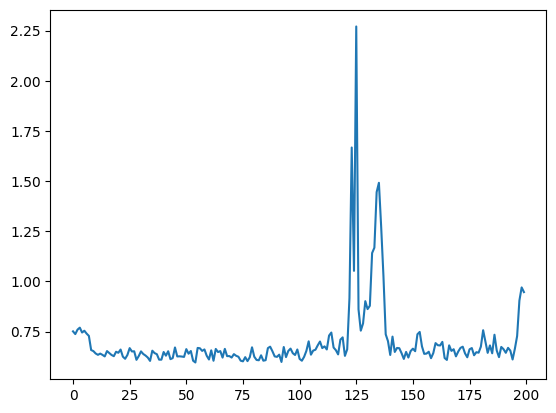

Train Accuracies


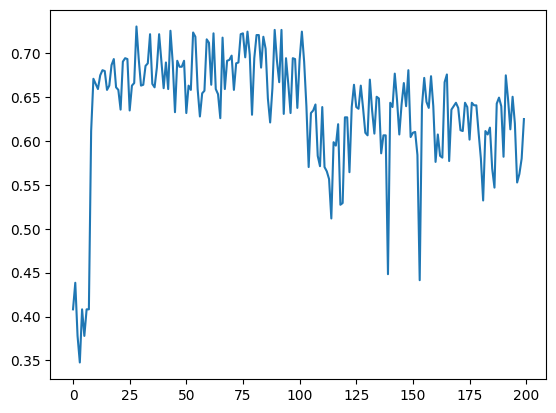

Validation Losses


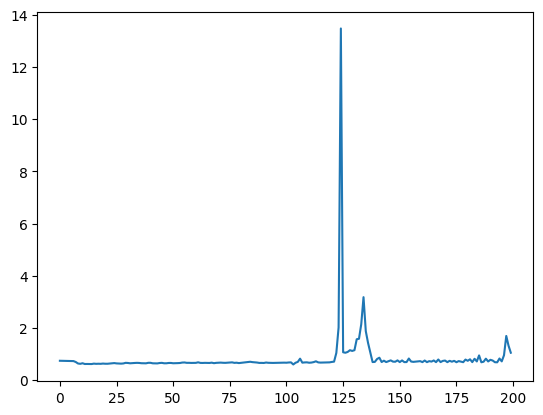

Validation Accuracies


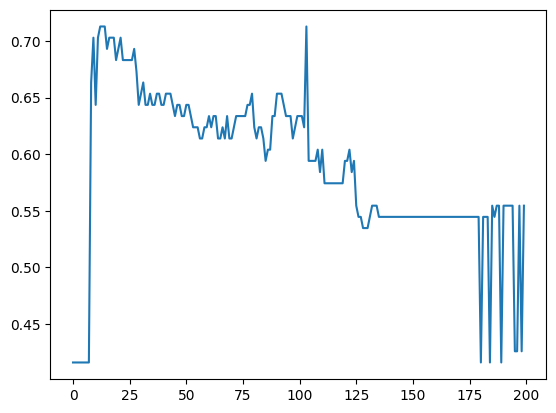

In [16]:
print("Train Losses")
plt.plot(train_losses)
plt.show()
print("Train Accuracies")
plt.plot(train_accuracies)
plt.show()
print("Validation Losses")
plt.plot(val_losses)
plt.show()
print("Validation Accuracies")
plt.plot(val_accuracies)
plt.show()

## Performance on the test set

In [17]:
seed_everything(77)
model.eval()
test_loss = 0.0
test_acc=0.0
for i, data in enumerate(tqdm(test_loader)):
        data = data.to(device)
        pred = model(data.x, data.edge_index, data.batch, data.y.shape[0])
        loss = criterion(pred.squeeze(), data.y.type(torch.float))
        probs=sigmoid(pred.squeeze())
        acc=accuracy_score(data.y.cpu(),torch.round(probs).detach().cpu())
        test_acc+=acc
        test_loss += loss.item()

epoch_test_loss=test_loss/len(test_loader) # Average test loss
epoch_test_accuracy=test_acc/len(test_loader) #Average test accuracy
print(f"Test loss epoch {epoch}: ", epoch_test_loss)
print(f"Test accuracy epoch {epoch}: ", epoch_test_accuracy)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.43it/s]

Test loss epoch 199:  0.948885440826416
Test accuracy epoch 199:  0.5982142857142857


## Further Results

Apparently, using this convolutional layer with embedded attention decreases performaces. We remind that to have a complete map of our tests, please look at experiments.pdf in this repository.